In [4]:
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import os, boto3, io

BUCKET = os.getenv("BUCKET")
LOCAL = "../local_data/"
CHAMPIONS_PROCESSED_DATA_PATH = os.getenv("CHAMPIONS_PROCESSED_DATA_PATH")
SINGLE_USER_PROCESSED_DATA_PATH = os.getenv("SINGLE_USER_PROCESSED_DATA_PATH")

CHAMPION_X_ROLE = "../local_data/champion_x_role_spark_output.csv"
CHAMPION_X_ROLE_X_USER = "../local_data/champion_x_role_x_user_spark_output.csv"
SINGLE_USER = "../local_data//single_user_spark_output.csv"

CHAMPION_X_ROLE = "../local_data/champion_x_role_spark_output.csv"
CHAMPION_X_ROLE_X_USER = "../local_data/champion_x_role_x_user_spark_output.csv"
SINGLE_USER = "../local_data//single_user_spark_output.csv"

In [ ]:
# 1) configure your bucket & key
key    = "processed_data/champion_data/patch_15_6/aggregated1.csv"

# 2) pull the object
s3 = boto3.client("s3")
obj = s3.get_object(Bucket=BUCKET, Key=key)

# 3) read it straight into pandas
df = pd.read_csv(io.BytesIO(obj["Body"].read()))

print(df.shape)

def get_processed_data_file(granularity: str) -> pd.DataFrame:
    

In [7]:
pd.set_option("display.max_columns", None)

champion_x_role_df = pd.read_csv(CHAMPION_X_ROLE)
display(champion_x_role_df)

,champion_id,champion_name,team_position,total_games_played_in_role,total_games_per_champion,avg_kills,avg_deaths,avg_deaths_by_enemy_champs,avg_assists,avg_kill_participation,avg_takedowns,total_wins,pct_of_games_with_highest_damage_dealt,avg_pct_damage_dealt_in_team,average_damage_per_minute,avg_damage_dealt_to_champions,avg_total_damage_dealt,avg_magic_damage_dealt_to_champions,avg_total_magic_damage_dealt,avg_physical_damage_dealt_to_champions,avg_total_physical_damage_dealt,avg_true_damage_dealt_to_champions,avg_total_true_damage_dealt,avg_largest_critical_strike,avg_pct_damage_taken_in_team,avg_damage_taken,avg_magic_damage_taken,avg_physical_damage_taken,avg_true_damage_taken,avg_damage_self_mitigated,avg_times_killed_champ_took_full_team_damage_and_survived,avg_times_survived_single_digit_hp,avg_times_survived_three_immobilizes_in_fight,avg_times_took_large_damage_survived,pct_of_games_with_highest_crowd_control_score,avg_time_ccing_others,avg_times_applied_cc_on_others,avg_enemy_champion_immobilizations,avg_total_healing,avg_heals_on_teammate,avg_total_units_healed,avg_dmg_shielded_on_team,avg_effective_heal_and_shield,total_games_completed_supp_quest_first,avg_supp_quest_completion_time,avg_longest_time_spent_alive,avg_time_spent_dead,avg_spell1_casts,avg_spell2_casts,avg_spell3_casts,avg_spell4_casts,avg_ability_uses,avg_times_dodged_skillshot_in_small_window,avg_skillshots_dodged,avg_skillshots_landed_early_game,avg_skillshots_hit,avg_times_immobilize_and_kill_with_ally,avg_times_got_kill_after_hidden_with_ally,avg_times_pick_kill_with_ally,avg_times_knock_enemy_into_team_and_kill,avg_kills_near_enemy_turret,avg_kills_under_own_turret,avg_multikills_after_aggressive_flash,avg_outnumbered_kills,avg_times_outnumbered_nexus_kill,avg_times_quick_cleanse,avg_quick_solo_kills,avg_solo_kills,avg_takedowns_after_gaining_lvl_advantage,avg_kills_on_other_lanes_early_as_jungler,avg_times_save_ally_from_death,avg_takedowns_in_alcove,pct_of_games_first_blood_kill,pct_of_games_first_blood_assist,avg_takedowns_before_jungle_camps_spawn,avg_first_takedown_time,avg_summoner_spell1_casts_per_game,avg_summoner_spell2_casts_per_game,pct_of_matches_with_ghost,pct_of_matches_with_cleanse,pct_of_matches_with_smite,pct_of_matches_with_teleport,pct_of_matches_with_exhaust,pct_of_matches_with_ignite,pct_of_matches_with_heal,pct_of_matches_with_flash,pct_of_matches_with_barrier,avg_champ_exp_at_game_end,avg_champ_level_at_game_end,avg_gold_earned_per_game,avg_gold_per_minute,avg_gold_spent,avg_bounty_lvl,avg_bounty_gold,pct_of_games_with_early_lane_phase_gold_exp_adv,pct_of_games_with_lanephase_gold_exp_adv,avg_max_level_lead_over_lane_opp,avg_minions_killed,avg_minions_killed_by_10_mins,avg_max_cs_lead_over_lane_opponent,avg_consumables_purchased,avg_number_of_items_purchased,total_games_fastest_item_completion,avg_items_completed,avg_ally_jungle_minions_killed,avg_enemy_jungle_minions_killed,avg_jungle_monsters_cs,avg_buffs_stolen,avg_initial_buff_count,avg_epic_monster_kills_within_30s_of_spawn,avg_initial_crab_count,avg_crabs_per_game,avg_jg_cs_before_10m,avg_jungler_kills_early_jungle,avg_jungler_early_kills_on_laners,avg_times_had_early_takedowns_in_all_lanes_as_laner,avg_jungler_takedowns_near_damaged_epic_monsters,avg_kills_with_help_from_epic_monster,avg_vision_score,avg_vision_score_per_min,avg_vision_score_advantage_over_lane_opponent,avg_stealth_wards_placed,avg_wards_placed,avg_wards_guarded,avg_control_wards_placed,avg_control_ward_time_coverage_in_river_or_enemy_half,avg_unseen_recalls,pct_of_games_with_highest_wards_killed,avg_wards_killed,avg_ward_takedowns,avg_ward_takedowns_before_20m,avg_times_2_wards_killed_with_1_sweeper,avg_control_wards_bought,pct_of_games_team_took_first_baron,avg_earliest_baron_by_team_time,pct_of_games_team_took_first_dragon,pct_of_games_team_took_first_inhib,pct_of_games_team_took_first_herald,pct_of_games_team_took_first_turret,avg_baron_kills_by_team,avg_herald_kills_by_team,avg_dragon_kills_by_

In [8]:
df = champion_x_role_df
# Creating features
df["total_role_games"] = df.groupby("team_position")["total_games_played_in_role"].transform("sum")
# Popularity metrics
df["popularity_in_role"] = df["total_games_played_in_role"]/df["total_role_games"]
df["role_popularity_for_champion"] = df["total_games_played_in_role"]/df["total_games_per_champion"]
# Damage done metrics
df["pct_magic_damage"] = df["avg_magic_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
df["pct_physical_damage"] = df["avg_physical_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
df["pct_true_damage"] = df["avg_true_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
# Damage taken metrics
df["avg_damage_taken_per_death"] = df["avg_damage_taken"]/df["avg_deaths"]
# JUNGLE (REVISIT UPSTREAM)
df["avg_kills_on_other_lanes_as_laner"] = np.where( 
    df["team_position"] != "JUNGLE", 
    df["avg_kills_on_other_lanes_early_as_jungler"], # As a laner, in a single game, get kills before 10 minutes outside your lane (anyone but your lane opponent)
    pd.NA
)
df["avg_kills_early_jungle_as_jungler"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_jungler_kills_early_jungle"], # As jungler, get kills on the enemy jungler in their own jungle before 10 minutes
    pd.NA
)
df["avg_early_kills_on_laners_as_jungler"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_jungler_early_kills_on_laners"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["avg_times_had_early_takedowns_in_all_lanes_as_laner"] = np.where(
    df["team_position"] != "JUNGLE", 
    df["avg_times_had_early_takedowns_in_all_lanes_as_laner"], # As a laner, get a takedown in all three lanes within 10 minutes
    pd.NA
)

# Structures
df["avg_individual_tower_assists"] = df["avg_individual_tower_takedowns"] - df["avg_individual_tower_kills"]


In [ ]:
labels = ["team_position", "champion_name"]

raw_clustering_features = [
    "avg_kills",
    "avg_deaths",
    "avg_assists",
    "avg_kill_participation",
    "avg_pct_damage_dealt_in_team",
    "average_damage_per_minute",
    "avg_damage_dealt_to_champions",
    "avg_damage_self_mitigated",
    "avg_times_killed_champ_took_full_team_damage_and_survived",
    "avg_times_survived_three_immobilizes_in_fight",
    "avg_time_ccing_others",
    "avg_times_applied_cc_on_others",
    "avg_enemy_champion_immobilizations",
    "avg_total_healing",
    "avg_heals_on_teammate",
    "avg_dmg_shielded_on_team",
    "avg_spell4_casts",
    "avg_ability_uses",
    "avg_skillshots_dodged",
    "avg_skillshots_landed_early_game",
    "avg_skillshots_hit",
    "avg_times_immobilize_and_kill_with_ally",
    "avg_times_pick_kill_with_ally",
    "avg_times_knock_enemy_into_team_and_kill",
    "avg_kills_near_enemy_turret",
    "avg_outnumbered_kills",
    "avg_quick_solo_kills",
    "avg_solo_kills",
    "avg_takedowns_after_gaining_lvl_advantage",
    "avg_times_save_ally_from_death",
    "avg_takedowns_in_alcove",
    "avg_first_takedown_time",
    "pct_of_matches_with_ghost",
    "pct_of_matches_with_teleport",
    "pct_of_matches_with_ignite",
    "avg_champ_exp_at_game_end",
    "avg_gold_earned_per_game",
    "avg_gold_per_minute",
    "pct_of_games_with_early_lane_phase_gold_exp_adv", # End the early laning phase (7 minutes) with 20% more gold and experience than your role opponent on Summoner's 
    "pct_of_games_with_lanephase_gold_exp_adv", # End the laning phase (14 minutes) with 20% more gold and experience than your role opponent 
    "avg_max_level_lead_over_lane_opp",
    "avg_minions_killed",
    "avg_minions_killed_by_10_mins",
    "avg_cs_per_minute",
    "avg_max_cs_lead_over_lane_opponent",
    "avg_number_of_items_purchased",
    "total_games_fastest_item_completion",
    "avg_enemy_jungle_minions_killed",
    "avg_enemy_jungle_cs_differential_early",
    "avg_jungle_monsters_cs",
    "avg_buffs_stolen",
    "avg_initial_buff_count",
    "avg_epic_monster_kills_within_30s_of_spawn",
    "avg_initial_crab_count",
    "avg_crabs_per_game",
    "avg_jg_cs_before_10m",
    "avg_vision_score_per_min",
    "avg_vision_score_advantage_over_lane_opponent",
    "avg_stealth_wards_placed",
    "avg_ward_takedowns_before_20m",
    "pct_of_games_team_took_first_dragon",
    "pct_of_games_team_took_first_herald",
    "pct_of_games_team_took_first_turret",
    "avg_dragon_kills_by_team",
    "avg_elder_dragon_kills_w_opposing_soul",
    "pct_of_games_first_turret_taken_by_team",
    "avg_indiv_dmg_dealt_to_buildings",
    "avg_indiv_turret_plates_taken",
    "pct_of_games_indiv_killed_1st_tower",
    "pct_of_games_individual_had_1st_turret_assist",
    "avg_individual_tower_kills",
    "avg_individual_solo_towers_kills_late_game", # Destroy side lane turrets solo (majority damage dealt by you) after 14 minutes without dying
    "avg_individual_inhibitor_kills",
    "avg_individual_solo_baron_kills",
    "avg_individual_void_monster_kills",
    "pct_of_games_had_drag_takedown",
    "avg_time_played_per_game_minutes",
    "avg_doublekills",
    "avg_triplekills",
    "avg_quadrakills",
    "avg_pentakills",
    "avg_multikills_with_one_spell",
    "avg_killing_sprees",
    "avg_12_assist_streaks",
    "avg_mejai_full_stack_time", ## new
    "percent_of_games_with_fully_stacked_mejais", ## new
    "pct_of_matches_with_gold_per",
    "pct_of_matches_with_magic_resist",
    "pct_of_matches_with_jungle",
    "pct_of_matches_with_trinket",
    "pct_of_matches_with_consumable",
    "pct_of_matches_with_tenacity",
    "pct_of_matches_with_lane",
    "pct_of_matches_with_spell_block",
    "pct_of_matches_with_armor_penetration",
    "pct_of_matches_with_life_steal",
    "pct_of_matches_with_health",
    "pct_of_matches_with_attack_speed",
    "pct_of_matches_with_critical_strike",
    "pct_of_matches_with_ability_haste",
    "pct_of_matches_with_on_hit",
    "pct_of_matches_with_damage",
    "pct_of_matches_with_slow",
    "pct_of_matches_with_stealth",
    "pct_of_matches_with_active",
    "pct_of_matches_with_spell_damage",
    "pct_of_matches_with_mana_regen",
    "pct_of_matches_with_vision",
    "pct_of_matches_with_spell_vamp",
    "pct_of_matches_with_boots",
    "pct_of_matches_with_aura",
    "pct_of_matches_with_magic_penetration",
    "pct_of_matches_with_cooldown_reduction",
    "pct_of_matches_with_armor",
    "pct_of_matches_with_health_regen",
    "pct_of_matches_with_mana",
    "pct_of_matches_with_nonboots_movement"
]


derived_clustering_features = [
    "popularity_in_role", 
    "role_popularity_for_champion",
    "pct_magic_damage",
    "pct_physical_damage",
    "pct_true_damage",
    "avg_damage_taken_per_death",
    "avg_effective_heal_and_shield",
    "avg_kills_on_other_lanes_as_laner",
    "avg_kills_early_jungle_as_jungler",
    "avg_early_kills_on_laners_as_jungler",
    "avg_times_had_early_takedowns_in_all_lanes_as_laner",
    "avg_wards_guarded",
    "avg_control_ward_time_coverage_in_river_or_enemy_half",
    "avg_first_turret_kill_time_by_team",
    "avg_individual_tower_assists"
]

potential_features = [
    "pct_of_games_with_highest_damage_dealt",
    "avg_largest_critical_strike",
    "avg_pct_damage_taken_in_team",
    "avg_times_took_large_damage_survived", # Compare with 'avg_damage_taken_per_death' and likely choose 1
    "avg_supp_quest_completion_time",
    "pct_of_games_first_blood_kill",
    "pct_of_games_first_blood_assist",
    "avg_jungler_takedowns_near_damaged_epic_monsters",
    "avg_kills_with_help_from_epic_monster",
    "avg_control_wards_placed",
    "avg_ward_takedowns",
    "pct_of_games_team_took_first_baron",
    "pct_of_games_team_took_first_inhib",
    "avg_shortest_time_to_ace_from_1st_takedown",
    "pct_of_games_individual_killed_nexus",
    "avg_individual_dmg_dealt_to_objectives",
    "avg_individual_dragon_kills",
    "avg_objectives_stolen",
    "pct_of_games_had_drag_takedown_min_5_to_7",
    "pct_of_games_had_drag_takedown_min_7_to_11",
    "pct_of_games_had_drag_takedown_min_11_to_15",
    "pct_of_games_had_drag_takedown_min_15_plus",
    "avg_number_of_multikills",
    "avg_legendary_count",
    "avg_full_team_takedowns"    
]

low_value_features = [
    "total_wins",
    "avg_takedowns",
    "avg_total_damage_dealt",
    "avg_total_magic_damage_dealt",
    "avg_total_physical_damage_dealt",
    "avg_total_true_damage_dealt",
    "avg_damage_taken",
    "avg_magic_damage_taken",
    "avg_physical_damage_taken",
    "avg_true_damage_taken",
    "avg_times_survived_single_digit_hp",
    "pct_of_games_with_highest_crowd_control_score",
    "avg_total_units_healed",
    "total_games_completed_supp_quest_first",
    "avg_longest_time_spent_alive",
    "avg_time_spent_dead",
    "avg_spell1_casts",
    "avg_spell2_casts",
    "avg_spell3_casts",
    "avg_times_dodged_skillshot_in_small_window",
    "avg_times_got_kill_after_hidden_with_ally",
    "avg_kills_under_own_turret",
    "avg_multikills_after_aggressive_flash",
    "avg_times_outnumbered_nexus_kill",
    "avg_times_quick_cleanse",
    "avg_takedowns_before_jungle_camps_spawn",
    "avg_summoner_spell1_casts_per_game",
    "avg_summoner_spell2_casts_per_game",
    "pct_of_matches_with_smite",
    "pct_of_matches_with_cleanse",
    "pct_of_matches_with_heal",
    "pct_of_matches_with_flash",
    "pct_of_matches_with_barrier",
    "pct_of_matches_with_exhaust",
    "avg_champ_level_at_game_end",
    "avg_gold_spent",
    "avg_bounty_lvl",
    "avg_bounty_gold",
    "avg_consumables_purchased",
    "avg_items_completed",
    "avg_ally_jungle_minions_killed",
    "avg_vision_score",
    "avg_wards_placed",
    "avg_unseen_recalls",
    "pct_of_games_with_highest_wards_killed",
    "avg_wards_killed",
    "avg_times_2_wards_killed_with_1_sweeper",
    "avg_control_wards_bought",
    "avg_earliest_baron_by_team_time",
    "avg_baron_kills_by_team",
    "avg_herald_kills_by_team",
    "pct_of_games_with_perfect_drag_soul_taken",
    "avg_elder_dragon_kills_by_team",
    "avg_inhib_kills_by_team",
    "avg_tower_kills_by_team",
    "avg_inhibs_lost_by_team",
    "pct_of_games_with_nexus_lost_by_team",
    "avg_turrets_lost_by_team",
    "avg_total_team_champ_kills",
    "avg_team_aces_before_15_by_team",
    "avg_flawless_aces_by_team",
    "avg_max_kill_deficit",
    "pct_of_games_that_are_perfect_games",
    "avg_indiv_dmg_dealth_to_turrets",
    "pct_of_games_individual_took_1st_tower_quick",
    "avg_turrets_killed_before_plates_fell",
    "avg_indiv_towers_taken_w_rift_herald",
    "avg_individual_inhibitor_takedowns",
    "avg_individual_nexus_takedowns",
    "pct_of_games_with_open_nexus",
    "avg_individual_baron_kills",
    "avg_individual_baron_takedowns",
    "avg_individual_dragon_takedowns",
    "avg_individual_rift_herald_takedowns",
    "avg_objectives_stolen_assists",
    "avg_epic_monster_steals",
    "avg_epic_monster_steals_without_smite",
    "avg_epic_monsters_killed_near_enemy_jgler",
    "avg_earliest_drag_takedown",
    "avg_game_length",
    "pct_of_games_ended_in_early_ff",
    "pct_of_games_ended_in_ff",
    "pct_of_games_team_ffd",
    "avg_largest_multikill",
    "avg_killing_sprees2",
    "avg_largest_killing_spee",
    "avg_unreal_kills",
    "avg_elder_drag_multikills",
    "avg_times_blast_cone_enemy",
    "pct_of_games_danced_with_rift_herald",
    "avg_double_aces",
    "avg_fist_bump_participations",
    "avg_outer_turret_executes_before_10m",
    "avg_takedowns_in_enemy_fountain",
    "mode_individual_position", # Double check if these positional cols are useful
    "mode_lane",
    "mode_role",
    "mode_team_position",
    "pct_of_games_played_champ_select_position",
    "role_play_rate",
    "kda",
    "win_rate",
    "avg_cs",
    "pct_games_first_to_complete_item"
]

In [19]:
labels = ["team_position", "champion_name"]

jungle_specific_features = ["pct_of_matches_with_jungle", "avg_kills_early_jungle_as_jungler", "avg_early_kills_on_laners_as_jungler"]
laners_specific_features = ["avg_kills_on_other_lanes_as_laner", "avg_times_had_early_takedowns_in_all_lanes_as_laner"]

raw_clustering_features = [
    "avg_kills",
    "avg_deaths",
    "avg_assists",
    "avg_kill_participation",
    "avg_pct_damage_dealt_in_team",
    "average_damage_per_minute",
    "avg_damage_dealt_to_champions",
    "avg_damage_self_mitigated",
    "avg_times_killed_champ_took_full_team_damage_and_survived",
    "avg_times_survived_three_immobilizes_in_fight",
    "avg_time_ccing_others",
    "avg_times_applied_cc_on_others",
    "avg_enemy_champion_immobilizations",
    "avg_total_healing",
    "avg_heals_on_teammate",
    "avg_dmg_shielded_on_team",
    "avg_spell4_casts",
    "avg_ability_uses",
    "avg_skillshots_dodged",
    "avg_skillshots_landed_early_game",
    "avg_skillshots_hit",
    "avg_times_immobilize_and_kill_with_ally",
    "avg_times_pick_kill_with_ally",
    "avg_times_knock_enemy_into_team_and_kill",
    "avg_kills_near_enemy_turret",
    "avg_outnumbered_kills",
    "avg_quick_solo_kills",
    "avg_solo_kills",
    "avg_takedowns_after_gaining_lvl_advantage",
    "avg_times_save_ally_from_death",
    "avg_takedowns_in_alcove",
    "avg_first_takedown_time",
    "pct_of_matches_with_ghost",
    "pct_of_matches_with_teleport",
    "pct_of_matches_with_ignite",
    "avg_champ_exp_at_game_end",
    "avg_gold_earned_per_game",
    "avg_gold_per_minute",
    "pct_of_games_with_early_lane_phase_gold_exp_adv",
    "pct_of_games_with_lanephase_gold_exp_adv",
    "avg_max_level_lead_over_lane_opp",
    "avg_minions_killed",
    "avg_minions_killed_by_10_mins",
    "avg_cs_per_minute",
    "avg_max_cs_lead_over_lane_opponent",
    "avg_number_of_items_purchased",
    "total_games_fastest_item_completion",
    "avg_enemy_jungle_minions_killed",
    "avg_jungle_monsters_cs",
    "avg_buffs_stolen",
    "avg_initial_buff_count",
    "avg_epic_monster_kills_within_30s_of_spawn",
    "avg_initial_crab_count",
    "avg_crabs_per_game",
    "avg_jg_cs_before_10m",
    "avg_vision_score_per_min",
    "avg_vision_score_advantage_over_lane_opponent",
    "avg_stealth_wards_placed",
    "avg_ward_takedowns_before_20m",
    "pct_of_games_team_took_first_dragon",
    "pct_of_games_team_took_first_herald",
    "pct_of_games_team_took_first_turret",
    "avg_dragon_kills_by_team",
    "avg_elder_dragon_kills_w_opposing_soul",
    "pct_of_games_first_turret_taken_by_team",
    "avg_indiv_dmg_dealt_to_buildings",
    "avg_indiv_turret_plates_taken",
    "pct_of_games_indiv_killed_1st_tower",
    "pct_of_games_individual_had_1st_turret_assist",
    "avg_individual_tower_kills",
    "avg_individual_solo_towers_kills_late_game",
    "avg_individual_inhibitor_kills",
    "avg_individual_solo_baron_kills",
    "avg_individual_void_monster_kills",
    "pct_of_games_had_drag_takedown",
    "avg_time_played_per_game_minutes",
    "avg_doublekills",
    "avg_triplekills",
    "avg_quadrakills",
    "avg_pentakills",
    "avg_multikills_with_one_spell",
    "avg_killing_sprees",
    "avg_12_assist_streaks",
    "pct_of_matches_with_gold_per",
    "pct_of_matches_with_magic_resist",
    "pct_of_matches_with_jungle",
    "pct_of_matches_with_trinket",
    "pct_of_matches_with_consumable",
    "pct_of_matches_with_tenacity",
    "pct_of_matches_with_lane",
    "pct_of_matches_with_spell_block",
    "pct_of_matches_with_armor_penetration",
    "pct_of_matches_with_life_steal",
    "pct_of_matches_with_health",
    "pct_of_matches_with_attack_speed",
    "pct_of_matches_with_critical_strike",
    "pct_of_matches_with_ability_haste",
    "pct_of_matches_with_on_hit",
    "pct_of_matches_with_damage",
    "pct_of_matches_with_slow",
    "pct_of_matches_with_stealth",
    "pct_of_matches_with_active",
    "pct_of_matches_with_spell_damage",
    "pct_of_matches_with_mana_regen",
    "pct_of_matches_with_vision",
    "pct_of_matches_with_spell_vamp",
    "pct_of_matches_with_boots",
    "pct_of_matches_with_aura",
    "pct_of_matches_with_magic_penetration",
    "pct_of_matches_with_cooldown_reduction",
    "pct_of_matches_with_armor",
    "pct_of_matches_with_health_regen",
    "pct_of_matches_with_mana",
    "pct_of_matches_with_nonboots_movement"
]


derived_clustering_features = [
    "popularity_in_role", 
    "role_popularity_for_champion",
    "pct_magic_damage",
    "pct_physical_damage",
    "pct_true_damage",
    "avg_damage_taken_per_death",
    "avg_effective_heal_and_shield",
    "avg_kills_on_other_lanes_as_laner",
    "avg_kills_early_jungle_as_jungler",
    "avg_early_kills_on_laners_as_jungler",
    "avg_times_had_early_takedowns_in_all_lanes_as_laner",
    "avg_wards_guarded",
    "avg_control_ward_time_coverage_in_river_or_enemy_half",
    "avg_first_turret_kill_time_by_team",
    "avg_individual_tower_assists"
]

potential_features = [
    "pct_of_games_with_highest_damage_dealt",
    "avg_largest_critical_strike",
    "avg_pct_damage_taken_in_team",
    "avg_times_took_large_damage_survived", # Compare with 'avg_damage_taken_per_death' and likely choose 1
    "avg_supp_quest_completion_time",
    "pct_of_games_first_blood_kill",
    "pct_of_games_first_blood_assist",
    "avg_jungler_takedowns_near_damaged_epic_monsters",
    "avg_kills_with_help_from_epic_monster",
    "avg_control_wards_placed",
    "avg_ward_takedowns",
    "pct_of_games_team_took_first_baron",
    "pct_of_games_team_took_first_inhib",
    "avg_shortest_time_to_ace_from_1st_takedown",
    "pct_of_games_individual_killed_nexus",
    "avg_individual_dmg_dealt_to_objectives",
    "avg_individual_dragon_kills",
    "avg_objectives_stolen",
    "pct_of_games_had_drag_takedown_min_5_to_7",
    "pct_of_games_had_drag_takedown_min_7_to_11",
    "pct_of_games_had_drag_takedown_min_11_to_15",
    "pct_of_games_had_drag_takedown_min_15_plus",
    "avg_number_of_multikills",
    "avg_legendary_count",
    "avg_full_team_takedowns"    
]

low_value_features = [
    "total_wins",
    "avg_takedowns",
    "avg_total_damage_dealt",
    "avg_total_magic_damage_dealt",
    "avg_total_physical_damage_dealt",
    "avg_total_true_damage_dealt",
    "avg_damage_taken",
    "avg_magic_damage_taken",
    "avg_physical_damage_taken",
    "avg_true_damage_taken",
    "avg_times_survived_single_digit_hp",
    "pct_of_games_with_highest_crowd_control_score",
    "avg_total_units_healed",
    "total_games_completed_supp_quest_first",
    "avg_longest_time_spent_alive",
    "avg_time_spent_dead",
    "avg_spell1_casts",
    "avg_spell2_casts",
    "avg_spell3_casts",
    "avg_times_dodged_skillshot_in_small_window",
    "avg_times_got_kill_after_hidden_with_ally",
    "avg_kills_under_own_turret",
    "avg_multikills_after_aggressive_flash",
    "avg_times_outnumbered_nexus_kill",
    "avg_times_quick_cleanse",
    "avg_takedowns_before_jungle_camps_spawn",
    "avg_summoner_spell1_casts_per_game",
    "avg_summoner_spell2_casts_per_game",
    "pct_of_matches_with_smite",
    "pct_of_matches_with_cleanse",
    "pct_of_matches_with_heal",
    "pct_of_matches_with_flash",
    "pct_of_matches_with_barrier",
    "pct_of_matches_with_exhaust",
    "avg_champ_level_at_game_end",
    "avg_gold_spent",
    "avg_bounty_lvl",
    "avg_bounty_gold",
    "avg_consumables_purchased",
    "avg_items_completed",
    "avg_ally_jungle_minions_killed",
    "avg_vision_score",
    "avg_wards_placed",
    "avg_unseen_recalls",
    "pct_of_games_with_highest_wards_killed",
    "avg_wards_killed",
    "avg_times_2_wards_killed_with_1_sweeper",
    "avg_control_wards_bought",
    "avg_earliest_baron_by_team_time",
    "avg_baron_kills_by_team",
    "avg_herald_kills_by_team",
    "pct_of_games_with_perfect_drag_soul_taken",
    "avg_elder_dragon_kills_by_team",
    "avg_inhib_kills_by_team",
    "avg_tower_kills_by_team",
    "avg_inhibs_lost_by_team",
    "pct_of_games_with_nexus_lost_by_team",
    "avg_turrets_lost_by_team",
    "avg_total_team_champ_kills",
    "avg_team_aces_before_15_by_team",
    "avg_flawless_aces_by_team",
    "avg_max_kill_deficit",
    "pct_of_games_that_are_perfect_games",
    "avg_indiv_dmg_dealth_to_turrets",
    "pct_of_games_individual_took_1st_tower_quick",
    "avg_turrets_killed_before_plates_fell",
    "avg_indiv_towers_taken_w_rift_herald",
    "avg_individual_inhibitor_takedowns",
    "avg_individual_nexus_takedowns",
    "pct_of_games_with_open_nexus",
    "avg_individual_baron_kills",
    "avg_individual_baron_takedowns",
    "avg_individual_dragon_takedowns",
    "avg_individual_rift_herald_takedowns",
    "avg_objectives_stolen_assists",
    "avg_epic_monster_steals",
    "avg_epic_monster_steals_without_smite",
    "avg_epic_monsters_killed_near_enemy_jgler",
    "avg_earliest_drag_takedown",
    "avg_game_length",
    "pct_of_games_ended_in_early_ff",
    "pct_of_games_ended_in_ff",
    "pct_of_games_team_ffd",
    "avg_largest_multikill",
    "avg_killing_sprees2",
    "avg_largest_killing_spee",
    "avg_unreal_kills",
    "avg_elder_drag_multikills",
    "avg_times_blast_cone_enemy",
    "pct_of_games_danced_with_rift_herald",
    "avg_double_aces",
    "avg_fist_bump_participations",
    "avg_mejai_full_stack_time", # Needs fixing upstream
    "avg_outer_turret_executes_before_10m",
    "avg_takedowns_in_enemy_fountain",
    "mode_individual_position", # Double check if these positional cols are useful
    "mode_lane",
    "mode_role",
    "mode_team_position",
    "pct_of_games_played_champ_select_position",
    "role_play_rate",
    "kda",
    "win_rate",
    "avg_cs",
    "pct_games_first_to_complete_item"
]


In [ ]:
# Quick EDA on aggregated_stats.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

jungle_columns = labels + raw_clustering_features + derived_clustering_features
jungle_columns = [feature for feature in jungle_columns if feature not in laners_specific_features]
# Filter the data
intermediate_jungle_df = df[jungle_columns]
intermediate_jungle_df = intermediate_jungle_df[intermediate_jungle_df["team_position"] == "JUNGLE"]
filtered_jungle_df = intermediate_jungle_df[df["role_popularity_for_champion"] > 0.10]
print(f'Shape: {df.shape}')
filtered_jungle_df.head()

Shape: (834, 276)


,team_position,champion_name,avg_kills,avg_deaths,avg_assists,avg_kill_participation,avg_pct_damage_dealt_in_team,average_damage_per_minute,avg_damage_dealt_to_champions,avg_damage_self_mitigated,avg_times_killed_champ_took_full_team_damage_and_survived,avg_times_survived_three_immobilizes_in_fight,avg_time_ccing_others,avg_times_applied_cc_on_others,avg_enemy_champion_immobilizations,avg_total_healing,avg_heals_on_teammate,avg_dmg_shielded_on_team,avg_spell4_casts,avg_ability_uses,avg_skillshots_dodged,avg_skillshots_landed_early_game,avg_skillshots_hit,avg_times_immobilize_and_kill_with_ally,avg_times_pick_kill_with_ally,avg_times_knock_enemy_into_team_and_kill,avg_kills_near_enemy_turret,avg_outnumbered_kills,avg_quick_solo_kills,avg_solo_kills,avg_takedowns_after_gaining_lvl_advantage,avg_times_save_ally_from_death,avg_takedowns_in_alcove,avg_first_takedown_time,pct_of_matches_with_ghost,pct_of_matches_with_teleport,pct_of_matches_with_ignite,avg_champ_exp_at_game_end,avg_gold_earned_per_game,avg_gold_per_minute,pct_of_games_with_early_lane_phase_gold_exp_adv,pct_of_games_with_lanephase_gold_exp_adv,avg_max_level_lead_over_lane_opp,avg_minions_killed,avg_minions_killed_by_10_mins,avg_cs_per_minute,avg_max_cs_lead_over_lane_opponent,avg_number_of_items_purchased,total_games_fastest_item_completion,avg_enemy_jungle_minions_killed,avg_jungle_monsters_cs,avg_buffs_stolen,avg_initial_buff_count,avg_epic_monster_kills_within_30s_of_spawn,avg_initial_crab_count,avg_crabs_per_game,avg_jg_cs_before_10m,avg_vision_score_per_min,avg_vision_score_advantage_over_lane_opponent,avg_stealth_wards_placed,avg_ward_takedowns_before_20m,pct_of_games_team_took_first_dragon,pct_of_games_team_took_first_herald,pct_of_games_team_took_first_turret,avg_dragon_kills_by_team,avg_elder_dragon_kills_w_opposing_soul,pct_of_games_first_turret_taken_by_team,avg_indiv_dmg_dealt_to_buildings,avg_indiv_turret_plates_taken,pct_of_games_indiv_killed_1st_tower,pct_of_games_individual_had_1st_turret_assist,avg_individual_tower_kills,avg_individual_solo_towers_kills_late_game,avg_individual_inhibitor_kills,avg_individual_solo_baron_kills,avg_individual_void_monster_kills,pct_of_games_had_drag_takedown,avg_time_played_per_game_minutes,avg_doublekills,avg_triplekills,avg_quadrakills,avg_pentakills,avg_multikills_with_one_spell,avg_killing_sprees,avg_12_assist_streaks,pct_of_matches_with_gold_per,pct_of_matches_with_magic_resist,pct_of_matches_with_jungle,pct_of_matches_with_trinket,pct_of_matches_with_consumable,pct_of_matches_with_tenacity,pct_of_matches_with_lane,pct_of_matches_with_spell_block,pct_of_matches_with_armor_penetration,pct_of_matches_with_life_steal,pct_of_matches_with_health,pct_of_matches_with_attack_speed,pct_of_matches_with_critical_strike,pct_of_matches_with_ability_haste,pct_of_matches_with_on_hit,pct_of_matches_with_damage,pct_of_matches_with_slow,pct_of_matches_with_stealth,pct_of_matches_with_active,pct_of_matches_with_spell_damage,pct_of_matches_with_mana_regen,pct_of_matches_with_vision,pct_of_matches_with_spell_vamp,pct_of_matches_with_boots,pct_of_matches_with_aura,pct_of_matches_with_magic_penetration,pct_of_matches_with_cooldown_reduction,pct_of_matches_with_armor,pct_of_matches_with_health_regen,pct_of_matches_with_mana,pct_of_matches_with_nonboots_movement,popularity_in_role,role_popularity_for_champion,pct_magic_damage,pct_physical_damage,pct_true_damage,avg_damage_taken_per_death,avg_effective_heal_and_shield,avg_kills_early_jungle_as_jungler,avg_early_kills_on_laners_as_jungler,avg_wards_guarded,avg_control_ward_time_coverage_in_river_or_enemy_half,avg_first_turret_kill_time_by_team,avg_individual_tower_assists
0,MIDDLE,Zilean,2.766760,3.621508,10.705307,0.480971,0.152205,494.630289,14425.611732,11748.597765,0.000000,2.701117,26.723464,321.065642,26.899441,7918.858939,3225.590782,560.000000,7.506983,470.976257,28.804469,11.581006,60.357542,4.078212,11.107542,0.002793,0.593575,0.282123,0.000000,0.389665,0.006983,2.020950,0.046089,3

In [11]:
# Check for missing values
missing = filtered_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

avg_kills_early_jungle_as_jungler                      207
avg_early_kills_on_laners_as_jungler                   207
avg_kills_on_other_lanes_as_laner                       55
avg_times_had_early_takedowns_in_all_lanes_as_laner     55
dtype: int64

In [22]:
filtered_df.fillna(0, inplace=True)

C:\Users\17862\AppData\Local\Temp\ipykernel_13712\2090872159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna(0, inplace=True)


In [23]:
# Summary statistics for numeric columns
filtered_df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_kills,262.0,5.496836,1.839468,0.812132,4.356575,5.663968,6.776394,9.262436
avg_deaths,262.0,5.600392,0.673598,3.463319,5.158738,5.574105,5.989464,8.001170
avg_assists,262.0,7.704718,2.857806,3.714672,5.608690,6.888346,9.185200,15.814815
avg_kill_participation,262.0,0.466324,0.070317,0.301456,0.412757,0.472334,0.518428,0.622386
avg_pct_damage_dealt_in_team,262.0,0.205039,0.045233,0.062123,0.188017,0.215042,0.237969,0.295541
...,...,...,...,...,...,...,...,...
avg_early_kills_on_laners_as_jungler,262.0,0.247580,0.493906,0.000000,0.000000,0.000000,0.000000,1.644831
avg_wards_guarded,262.0,0.386927,0.167022,0.091127,0.245246,0.372838,0.471853,0.971033
avg_control_ward_time_coverage_in_river_or_enemy_half,262.0,0.529367,0.043978,0.405989,0.507491,0.540635,0.559805,0.631117
avg_first_turret_kill_time_by_team,262.0,832.607111,11.383506,784.741877,828.070450,834.168414,839.291525,860.142458


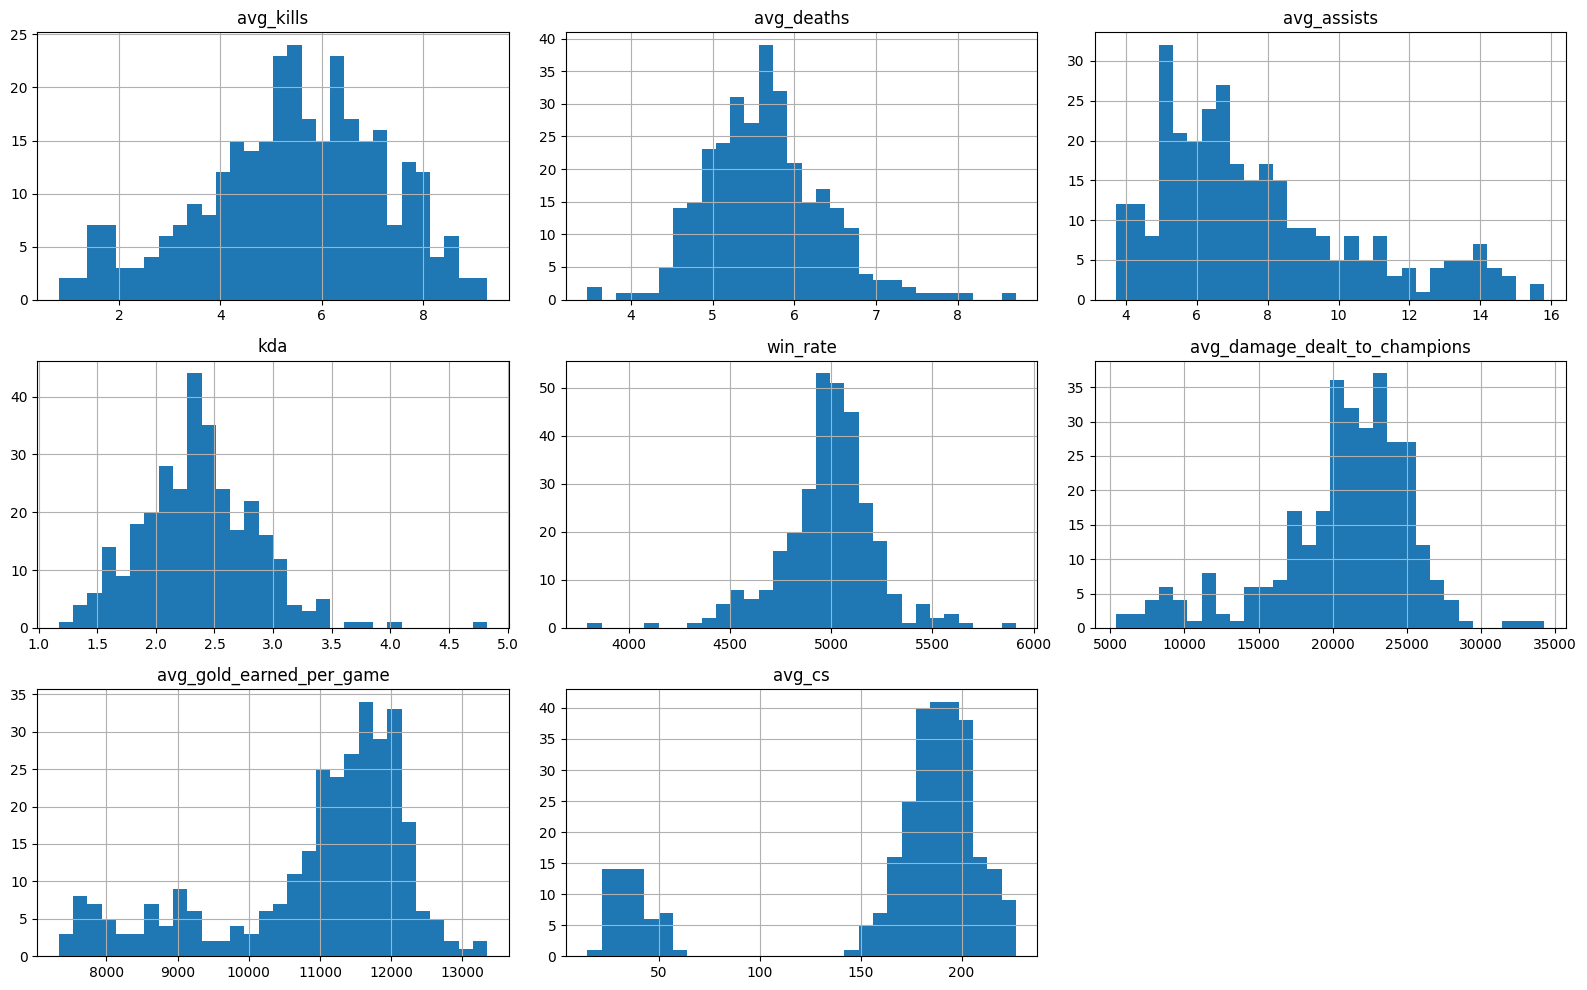

In [ ]:
# Plot distributions of a few key features
features = ['avg_kills', 'avg_deaths', 'avg_assists', 'kda', 'win_rate', 'avg_damage_dealt_to_champions', 'avg_gold_earned_per_game', 'avg_cs']
filtered_df[features].hist(bins=30, figsize=(16, 10))
plt.tight_layout()
plt.show()

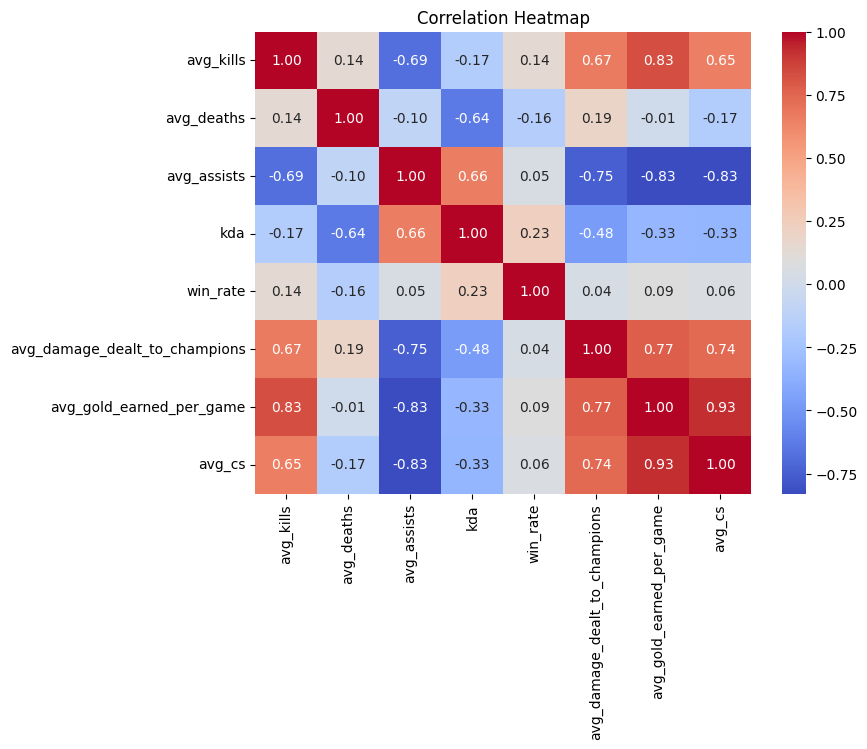

In [6]:
# Correlation heatmap for a subset of features
corr = df[features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

label_cols = ['champion_name', 'team_position']

# Setup
label_cols = ['champion_name', 'team_position']
jungle_df = filtered_df[filtered_df["team_position"] == "JUNGLE"]
feature_cols = [col for col in jungle_df.columns if col not in label_cols]
X = jungle_df[feature_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
k_manual = 10  # Predetermined number of clusters
kmeans = KMeans(n_clusters=k_manual, random_state=42, n_init=10)
jungle_df['cluster'] = kmeans.fit_predict(X_scaled)

# Print clusters and their members
print("=== Jungle Champion Clusters ===")
for cluster_num in range(k_manual):
    members = jungle_df[jungle_df['cluster'] == cluster_num][['champion_name']]
    print(f"\nCluster {cluster_num} ({len(members)} champions):")
    print(members['champion_name'].to_string(index=False))

# Calculate and display feature importance for each cluster
centroids = kmeans.cluster_centers_
feature_importance = np.ptp(centroids, axis=0)  # Range of centroid values
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

print("\n=== Top 10 Most Poggers Features ===")
print(importance_df.head(10).to_string(index=False))

=== Jungle Champion Clusters ===

Cluster 0 (6 champions):
   Udyr
   Ekko
Shyvana
DrMundo
   Gwen
  Diana

Cluster 1 (6 champions):
    Yorick
   Belveth
MonkeyKing
      Olaf
   Trundle
       Jax

Cluster 2 (11 champions):
 Warwick
  RekSai
Pantheon
   Briar
   Poppy
Nocturne
JarvanIV
  Darius
 XinZhao
Volibear
      Vi

Cluster 3 (8 champions):
   Kayn
 Rengar
    Zed
 Qiyana
 Khazix
Hecarim
Naafiri
  Talon

Cluster 4 (7 champions):
Sejuani
 Maokai
  Amumu
    Zac
Skarner
 Rammus
   Nunu

Cluster 5 (4 champions):
MasterYi
 Kindred
   Viego
  Graves

Cluster 6 (7 champions):
      Lillia
       Shaco
     Taliyah
        Zyra
      Rumble
FiddleSticks
     Karthus

Cluster 7 (4 champions):
Nidalee
 Gragas
Evelynn
  Elise

Cluster 8 (1 champions):
Ivern

Cluster 9 (1 champions):
LeeSin

=== Top 10 Most Poggers Features ===
                       feature  importance
pct_of_matches_with_mana_regen    7.483503
      avg_dmg_shielded_on_team    7.466147
 avg_effective_heal_and_shield    

C:\Users\17862\AppData\Local\Temp\ipykernel_13712\2200446979.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jungle_df['cluster'] = kmeans.fit_predict(X_scaled)



=== Clustering for role: UTILITY ===


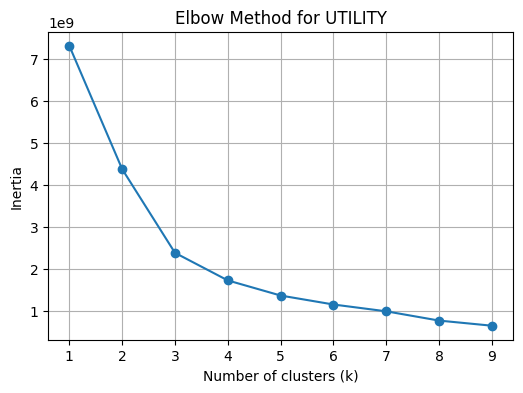


  Cluster 0 (12 champions):
   Alistar
    Maokai
    Thresh
     Braum
     Poppy
 TahmKench
     Leona
     Rakan
  Nautilus
     Taric
Blitzcrank
      Rell

  Cluster 1 (11 champions):
   Zilean
     Sona
    Milio
    Karma
    Senna
    Yuumi
     Lulu
    Janna
Seraphine
   Soraka
     Nami

  Cluster 2 (16 champions):
  Xerath
   Swain
   Shaco
Pantheon
    Pyke
   Neeko
    Bard
 Morgana
    Zyra
  Velkoz
   Brand
     Lux
   Elise
  Renata
     Zoe
     Mel

=== Clustering for role: BOTTOM ===


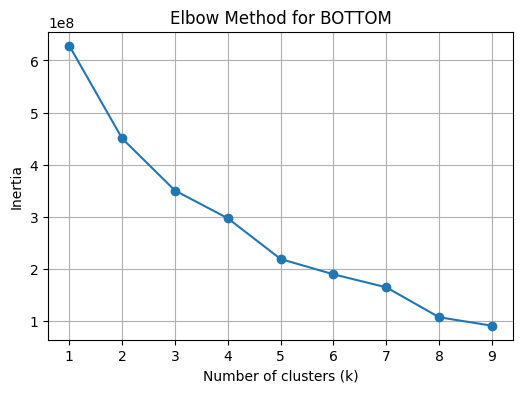


  Cluster 0 (19 champions):
     Twitch
       Jinx
       Ashe
       Jhin
      Varus
      Kaisa
       Zeri
   Tristana
    Caitlyn
MissFortune
     Lucian
      Sivir
     Ezreal
      Xayah
   Aphelios
      Corki
    Smolder
     KogMaw
     Veigar

  Cluster 1 (5 champions):
   Hwei
  Brand
Karthus
  Ziggs
    Mel

  Cluster 2 (7 champions):
  Kalista
    Swain
   Draven
   Samira
    Nilah
Seraphine
    Vayne

=== Clustering for role: MIDDLE ===


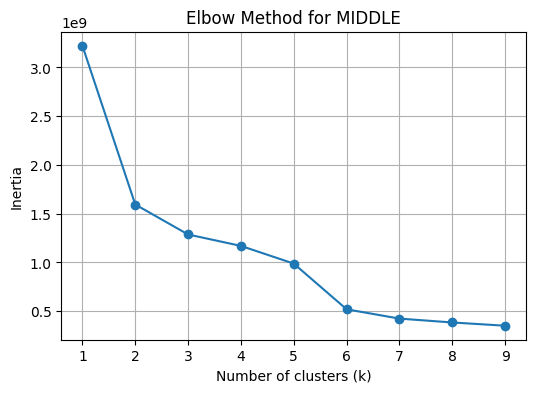


  Cluster 0 (30 champions):
     Orianna
      Xerath
     Leblanc
    Katarina
Heimerdinger
      Aurora
        Hwei
 AurelionSol
      Akshan
       Neeko
         Vex
      Syndra
 TwistedFate
     Taliyah
        Azir
      Velkoz
        Ahri
      Qiyana
       Quinn
       Annie
    Malzahar
       Ziggs
       Kayle
         Lux
      Kennen
         Zoe
        Fizz
         Mel
      Veigar
   Lissandra

  Cluster 1 (6 champions):
    Yone
   Galio
Vladimir
 Chogath
  Irelia
   Yasuo

  Cluster 2 (14 champions):
    Viktor
    Anivia
     Jayce
     Swain
     Akali
      Ekko
      Ryze
Cassiopeia
       Zed
  Kassadin
   Naafiri
     Sylas
     Diana
     Talon

=== Clustering for role: TOP ===


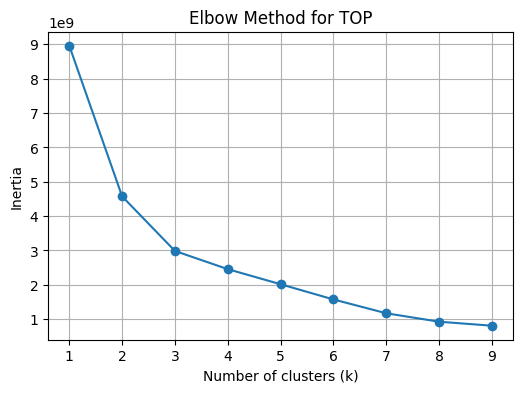


  Cluster 0 (26 champions):
       Yone
    Warwick
 MonkeyKing
     Illaoi
       Olaf
    Chogath
     Irelia
    Camille
       Sett
      Riven
      Urgot
    DrMundo
      Nasus
   Renekton
     Aatrox
     Singed
     Gragas
     Darius
Mordekaiser
      Fiora
 Tryndamere
    Ambessa
      Garen
    Trundle
       Kled
        Jax

  Cluster 1 (17 champions):
      Yorick
Heimerdinger
       Jayce
      Aurora
    Vladimir
    Pantheon
       Akali
        Ryze
      Rumble
  Cassiopeia
        Gnar
       Teemo
   Gangplank
       Quinn
       Kayle
      Kennen
        Gwen

  Cluster 2 (8 champions):
 Malphite
     Ornn
     Shen
    Poppy
   KSante
     Sion
TahmKench
 Volibear

=== Clustering for role: JUNGLE ===


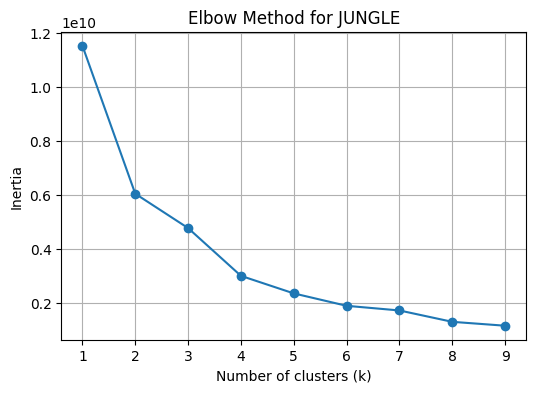


  Cluster 0 (17 champions):
   Warwick
      Kayn
MonkeyKing
    RekSai
    Lillia
     Amumu
  Pantheon
   Shyvana
     Briar
  Nocturne
    Darius
   XinZhao
      Nunu
   Hecarim
        Vi
    LeeSin
     Diana

  Cluster 1 (10 champions):
 Sejuani
    Udyr
    Olaf
     Zac
 DrMundo
 Skarner
   Poppy
JarvanIV
  Rammus
Volibear

  Cluster 2 (22 champions):
       Ivern
     Belveth
    MasterYi
       Shaco
     Kindred
        Ekko
     Nidalee
     Taliyah
        Zyra
      Rengar
FiddleSticks
       Viego
         Zed
      Qiyana
     Evelynn
     Karthus
      Khazix
      Graves
       Elise
     Naafiri
        Gwen
       Talon


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

label_cols = ['champion_name', 'team_position']

jungle_df = filtered_df[filtered_df["team_position"] == "JUNGLE"]
feature_cols = [col for col in jungle_df.columns if col not in label_cols]
X = jungle_df[feature_cols]

inertia = []
k_range = range(1, min(10, len(jungle_df)))  # Don't exceed number of samples
k_manual = 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
kmeans = KMeans(n_clusters=k_manual, random_state=42)
for role in filtered_df['team_position'].unique():
    print(f"\n=== Clustering for role: {role} ===")
    df_role = filtered_df[filtered_df['team_position'] == role].reset_index(drop=True)
    
    # Exclude label columns
    feature_cols = [col for col in df_role.columns if col not in label_cols]
    X = df_role[feature_cols]
    
    # One-hot encode categorical columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X_encoded = pd.get_dummies(X, columns=cat_cols)
    
    # Elbow method
    inertia = []
    k_range = range(1, min(10, len(df_role)))  # Don't exceed number of samples
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_encoded)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(6, 4))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {role}')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    
    # Choose a number of clusters (e.g., 3, or prompt user to pick based on elbow)
    n_clusters = 3 if len(df_role) >= 3 else 1
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_role['cluster'] = kmeans.fit_predict(X_encoded)
    
    # List all champions in each cluster for this role
    for cluster_num in sorted(df_role['cluster'].unique()):
        members = df_role[df_role['cluster'] == cluster_num][['champion_name']]
        print(f"\n  Cluster {cluster_num} ({len(members)} champions):")
        print(members['champion_name'].to_string(index=False))

In [37]:
import numpy as np
import pandas as pd

for role in filtered_df['team_position'].unique():
    print(f"\n=== Feature Impact for role: {role} ===")
    df_role = filtered_df[filtered_df['team_position'] == role].reset_index(drop=True)
    feature_cols = [col for col in df_role.columns if col not in label_cols]
    X = df_role[feature_cols]
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X_encoded = pd.get_dummies(X, columns=cat_cols)
    
    n_clusters = 3 if len(df_role) >= 3 else 1
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_encoded)
    
    # Calculate feature importance as the range of centroid values for each feature
    centroids = kmeans.cluster_centers_
    feature_importance = np.ptp(centroids, axis=0)  # ptp = max - min (range)
    importance_df = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=False)
    
    print(importance_df.head(10).to_string(index=False))  # Show top 10 features


=== Feature Impact for role: MIDDLE ===
                            feature   importance
          avg_damage_self_mitigated 42517.559728
                  avg_total_healing  6602.885780
      avg_damage_dealt_to_champions  4267.362605
   avg_indiv_dmg_dealt_to_buildings  2727.575373
         avg_damage_taken_per_death  2637.240161
     avg_times_applied_cc_on_others   643.944430
          avg_champ_exp_at_game_end   422.035678
           avg_dmg_shielded_on_team   334.451649
      avg_effective_heal_and_shield   334.069901
total_games_fastest_item_completion   225.344828

=== Feature Impact for role: UTILITY ===
                         feature   importance
       avg_damage_self_mitigated 20185.048857
   avg_effective_heal_and_shield 11502.653329
               avg_total_healing  9503.209196
           avg_heals_on_teammate  7708.400582
   avg_damage_dealt_to_champions  7155.092125
        avg_dmg_shielded_on_team  3793.619860
      avg_damage_taken_per_death   824.183788
        av

In [38]:
import pandas as pd
from sklearn.cluster import KMeans

# 1. Exclude label columns
label_cols = ['champion_name', 'team_position']
feature_cols = [col for col in filtered_df.columns if col not in label_cols]

# 2. Select features
X = filtered_df[feature_cols]

# 3. One-hot encode all categorical columns (object or category dtype)
X_encoded = pd.get_dummies(X)

# 4. Clustering
n_clusters = 25  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
filtered_df['cluster'] = kmeans.fit_predict(X_encoded)

# 5. Show results with labels and cluster assignment
filtered_df[['champion_name', 'team_position', 'cluster']].head(100)

C:\Users\17862\AppData\Local\Temp\ipykernel_20392\925980330.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster'] = kmeans.fit_predict(X_encoded)


,champion_name,team_position,cluster
0,Zilean,MIDDLE,21
1,Zilean,UTILITY,22
4,Twitch,BOTTOM,14
9,Orianna,MIDDLE,0
14,Yone,TOP,4
...,...,...,...
246,Neeko,UTILITY,10
247,Neeko,MIDDLE,0
249,Neeko,JUNGLE,15
251,Draven,BOTTOM,0


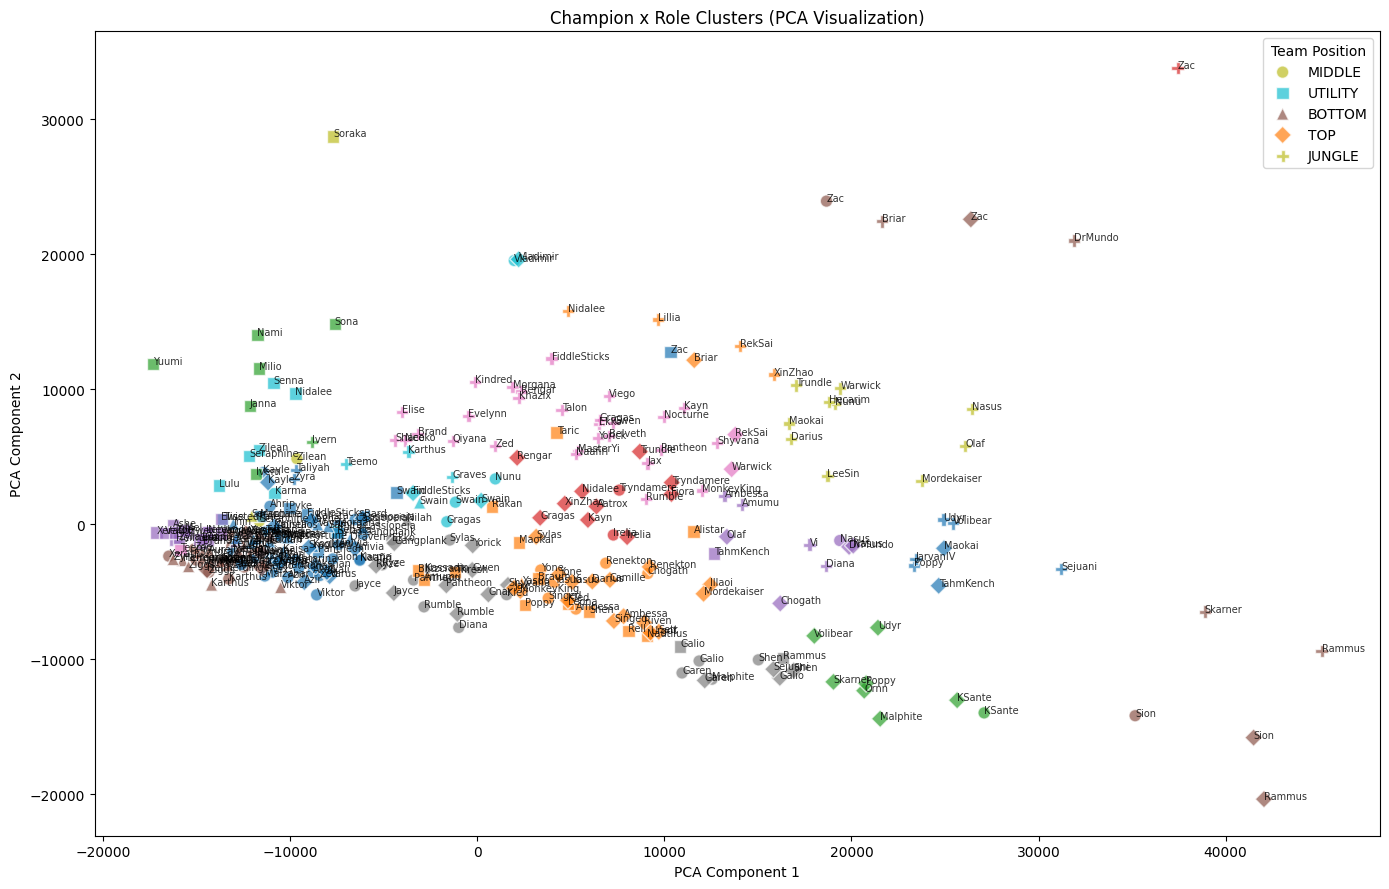

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_encoded)

# Define marker styles for each team position
team_positions = filtered_df['team_position'].unique()
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>']  # Add more if needed
marker_dict = {pos: markers[i % len(markers)] for i, pos in enumerate(team_positions)}

plt.figure(figsize=(14, 9))

for pos in team_positions:
    idx = filtered_df['team_position'] == pos
    plt.scatter(
        X_pca[idx, 0], X_pca[idx, 1],
        c=filtered_df.loc[idx, 'cluster'],
        cmap='tab10',
        marker=marker_dict[pos],
        label=pos,
        alpha=0.7,
        edgecolors='w',
        s=80
    )
    # Add champion name labels for this team position
    for i in np.where(idx)[0]:
        plt.text(
            X_pca[i, 0], X_pca[i, 1],
            filtered_df.iloc[i]['champion_name'],
            fontsize=7, alpha=0.8
        )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Champion x Role Clusters (PCA Visualization)')
plt.legend(title='Team Position')
plt.tight_layout()
plt.show()

In [40]:
# List all champion-role combos in each cluster
for cluster_num in sorted(filtered_df['cluster'].unique()):
    members = filtered_df[filtered_df['cluster'] == cluster_num][['champion_name', 'team_position']]
    print(f"\nCluster {cluster_num} ({len(members)} members):")
    print(members.to_string(index=False))


Cluster 0 (59 members):
champion_name team_position
      Orianna        MIDDLE
         Jinx        BOTTOM
      Kalista        BOTTOM
      Kalista           TOP
       Viktor        MIDDLE
       Anivia        MIDDLE
       Anivia           TOP
     Katarina        MIDDLE
         Jhin        BOTTOM
        Varus        BOTTOM
        Varus           TOP
       Akshan        MIDDLE
       Akshan           TOP
        Akali        MIDDLE
        Akali           TOP
        Neeko        MIDDLE
       Draven        BOTTOM
          Vex        MIDDLE
       Samira        BOTTOM
        Kaisa        BOTTOM
      Morgana        MIDDLE
  TwistedFate        MIDDLE
      Taliyah        JUNGLE
         Azir        MIDDLE
         Azir           TOP
         Zyra        JUNGLE
         Zeri        BOTTOM
     Tristana        BOTTOM
     Tristana        MIDDLE
      Caitlyn        BOTTOM
   Cassiopeia        MIDDLE
   Cassiopeia           TOP
   Cassiopeia        BOTTOM
  MissFortune        BO